In [1]:
import torchvision
from torchvision import transforms, datasets, utils
import torch as torch
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import itertools
import time
import numpy as np
from sklearn.metrics import precision_score, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def mymshow(img, std, mean, fig_size=[8,8]):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    fig,ax = plt.subplots()
    fig.set_size_inches(*fig_size)
    ax.imshow(img)
    plt.show()

In [4]:
class AverageMeter(object):
    def __init__(self):
        self.avg = 0
        self.sum = 0
        self.count = 0 

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [83]:
mean,std=[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
compose = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = torchvision.datasets.CelebA('celeba',split='train',target_type='attr', transform=compose, download=True)
valid_dataset = torchvision.datasets.CelebA('celeba',split='valid',target_type='attr', transform=compose, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
all_attributes = '5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young'.split(' ')
relevant_attributes = ['Black_Hair', 'Blond_Hair', 'Eyeglasses','Smiling' ]

In [85]:
relevant_indices = []
for i, a in enumerate(all_attributes):
    if a in relevant_attributes:
        relevant_indices.append(i)
relevant_indices = torch.tensor(relevant_indices)

In [86]:
index_to_string = {i:all_attributes[j.item()] for i,j in enumerate(relevant_indices)}
index_to_string

{0: 'Black_Hair', 1: 'Blond_Hair', 2: 'Eyeglasses', 3: 'Smiling'}

In [87]:
bs=256

In [88]:
train_dataloader = DataLoader(train_dataset, bs,shuffle=True, num_workers=1)
valid_dataloader = DataLoader(valid_dataset, bs,shuffle=False, num_workers=1)

In [89]:
class NNet(nn.Module):
    def __init__(self, num_attributes):
        super(NNet, self).__init__()
        self.classifier = torchvision.models.resnet18(pretrained=False)
        self.classifier.fc = nn.Linear(self.classifier.fc.in_features, num_attributes)
    def forward(self, xb):
        yhat = self.classifier(xb).sigmoid()
        return yhat
        
        
def gen_net_opt(lr, wd):
    classifier = NNet(len(relevant_attributes)).to(device)
    optimizer = torch.optim.Adam(classifier.parameters(),lr=lr,weight_decay=wd)
    return classifier, optimizer

In [90]:
# fit/test function
def single_epoch(dataloader, model, loss_function, optimizer=None):
    
    if optimizer != None:
        model.train()
    else:
        model.eval()

    losses = AverageMeter()
    f1 = [AverageMeter() for _ in relevant_attributes]
    for xb, yb in tqdm(dataloader,leave=False):
        yb = yb[:,relevant_indices].float()
        y_hat = model(xb.to(device))
        y = yb.to(device)
        loss = loss_function(y_hat, y)
            
        if optimizer != None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        batch_size = len(yb)
        losses.update(loss.item(), batch_size)
        [p.update(f1_score(y[:,i].cpu(),(y_hat>0.5).int()[:,i].cpu()),batch_size) for i,p in enumerate(f1)]

    return losses.avg, [round(p.avg,2) for p in f1]

def fit(epochs, model, train_dl, valid_dl, loss_func, optimizer, scheduler=None):
    for epoch in range(epochs):
        start_time = time.time()    
        train_loss, train_precisions = single_epoch(train_dl, model, loss_func, optimizer)
        if scheduler != None:
            scheduler.step()
        with torch.no_grad():
            valid_loss, valid_precisions = single_epoch(valid_dl, model, loss_func)
        secs = int(time.time() - start_time)
        print(f'Epoch {epoch} {secs}[sec]',end=' ')
        print(f'Train: loss {train_loss:.4f}. f1 {train_precisions}',end='\t')
        print(f'Valid: loss {valid_loss:.4f}. f1 {valid_precisions}')

In [91]:
lr=0.00005
wd=0.005
classifier,optimizer = gen_net_opt(lr,wd)
fit(10,classifier,train_dataloader,valid_dataloader,nn.BCELoss(),optimizer)
#Epoch 0 130[sec] Train: loss 0.1841. f1 [0.73, 0.79, 0.91, 0.89]	Valid: loss 0.1526. f1 [0.77, 0.82, 0.96, 0.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 0 253[sec] Train: loss 0.2483. f1 [0.64, 0.74, 0.58, 0.84]	Valid: loss 0.1893. f1 [0.72, 0.8, 0.75, 0.89]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 1 253[sec] Train: loss 0.1810. f1 [0.72, 0.8, 0.79, 0.9]	Valid: loss 0.1802. f1 [0.73, 0.8, 0.8, 0.9]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 2 252[sec] Train: loss 0.1664. f1 [0.75, 0.82, 0.83, 0.9]	Valid: loss 0.1708. f1 [0.74, 0.82, 0.82, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 3 253[sec] Train: loss 0.1569. f1 [0.76, 0.83, 0.86, 0.91]	Valid: loss 0.1709. f1 [0.61, 0.82, 0.84, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 4 262[sec] Train: loss 0.1504. f1 [0.77, 0.83, 0.88, 0.91]	Valid: loss 0.1639. f1 [0.76, 0.82, 0.79, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 5 262[sec] Train: loss 0.1453. f1 [0.77, 0.84, 0.9, 0.92]	Valid: loss 0.1536. f1 [0.76, 0.83, 0.85, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 6 259[sec] Train: loss 0.1403. f1 [0.78, 0.85, 0.91, 0.92]	Valid: loss 0.1590. f1 [0.7, 0.82, 0.85, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 7 258[sec] Train: loss 0.1353. f1 [0.79, 0.85, 0.92, 0.92]	Valid: loss 0.1654. f1 [0.76, 0.78, 0.87, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 8 254[sec] Train: loss 0.1315. f1 [0.8, 0.86, 0.92, 0.93]	Valid: loss 0.1606. f1 [0.76, 0.83, 0.87, 0.91]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f46e81ee290>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

Epoch 9 249[sec] Train: loss 0.1278. f1 [0.8, 0.86, 0.93, 0.93]	Valid: loss 0.1602. f1 [0.75, 0.83, 0.87, 0.91]


tensor([0, 0, 1, 0])
tensor([[False, False,  True, False]], device='cuda:0')


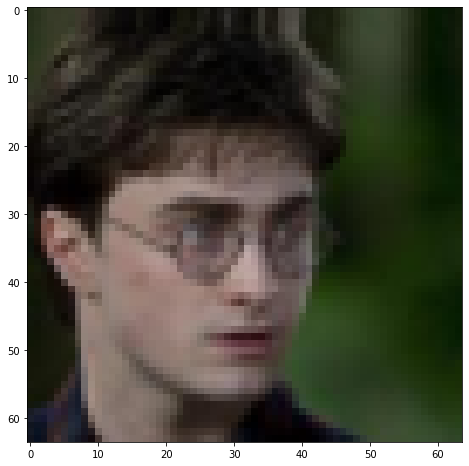

In [95]:
idx = 1130
classifier.eval()
print(valid_dataset[idx][1][relevant_indices])
with torch.no_grad():
    print(classifier(valid_dataset[idx][0].unsqueeze(0).to(device)) > 0.5)
mymshow(valid_dataset[idx][0],std,mean)      

In [96]:
torch.save(classifier.state_dict(), 'save_classifier.pt')

In [19]:
index_to_string

{0: 'Black_Hair', 1: 'Blond_Hair', 2: 'Eyeglasses', 3: 'Smiling'}